<a href="https://colab.research.google.com/github/tinycar2008/rnn-model-predict-stock/blob/main/rnn_assignment_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a RNN model




> Caroline Schor

In this assignment, build a RNN model to help predict Microsoft stock using LSTM.

Data can be downloaded from here: https://finance.yahoo.com/quote/MSFT/history?p=MSFT

Changes made:

1. Increase training dataset
2. Choose "close" feature instead of adjusted feature
3. Hyper parameter finetuning

* **RESULT**: RMSE: 11.704944234570315 a bit worse, but the trend looks closer to the real trend than before.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

### Prepare dataset

1. Define length of dataset - period : 5 years of data
2. Using "Close" price value

In [ ]:
pip install yfinance

In [ ]:
#Connect to Yahoo Finance

import yfinance as yf

data = yf.download(tickers='MSFT', period='5y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
num_rows_data = data.shape[0]
print("Number of rows in data DataFrame:", num_rows_data)

Number of rows in data DataFrame: 1258


In [ ]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2019-10-29 00:00:00+00:00,136.424042,142.830002,144.500000,142.649994,144.080002,20589500
2019-10-30 00:00:00+00:00,138.124222,144.610001,145.000000,142.789993,143.520004,18496600
2019-10-31 00:00:00+00:00,136.939804,143.369995,144.929993,142.990005,144.899994,24605100
2019-11-01 00:00:00+00:00,137.274170,143.720001,144.419998,142.970001,144.259995,33128400
2019-11-04 00:00:00+00:00,138.066940,144.550003,145.000000,144.160004,144.830002,16912000


In [ ]:
data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,279.483701,284.378609,287.119038,281.377233,284.316526,2.859252e+07
std,81.878215,80.087320,80.419884,79.690592,80.193913,1.270784e+07
min,130.141006,135.419998,140.570007,132.520004,137.009995,8.989200e+06
25%,220.255623,225.799999,229.122498,223.997505,226.522499,2.043615e+07
50%,270.496033,276.395004,279.309998,272.940002,276.830002,2.543580e+07
75%,328.628342,333.557495,336.675003,330.337509,334.317497,3.299920e+07
max,466.718781,467.559998,468.350006,464.459991,467.000000,9.701270e+07


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-10-29 00:00:00+00:00 to 2024-10-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, MSFT)  1259 non-null   float64
 1   (Close, MSFT)      1259 non-null   float64
 2   (High, MSFT)       1259 non-null   float64
 3   (Low, MSFT)        1259 non-null   float64
 4   (Open, MSFT)       1259 non-null   float64
 5   (Volume, MSFT)     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


### Define training and test data set

In [ ]:
train_dataset = data.iloc[:1200,1:2].values # increase to 1200
test_dataset = data.iloc[1132:,1:2].values

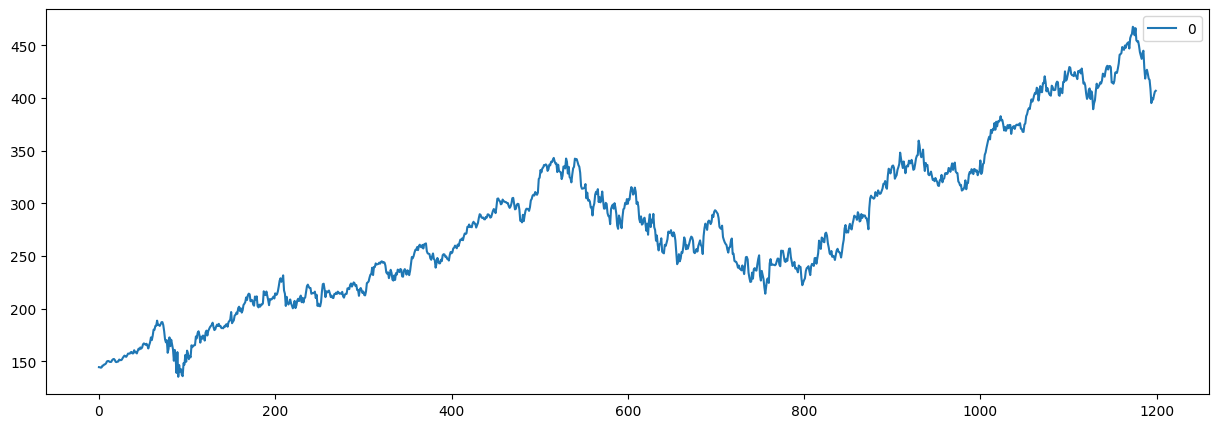

In [ ]:
#Plot Train Dataset

train_dataset_df = pd.DataFrame(train_dataset)

# Plot Train Dataset

plot = train_dataset_df.plot(figsize=(15,5))
plt.show() #Display the plot

In [ ]:
print(train_dataset)

[[142.83000183]
 [144.61000061]
 [143.36999512]
 ...
 [408.48999023]
 [395.1499939 ]
 [399.60998535]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
# Reshape train_dataset to a 2D array with one column using reshape(-1, 1)
training_set_scaled = sc.fit_transform(train_dataset.reshape(-1,1))
training_set_scaled

array([[0.02748842],
       [0.02721746],
       [0.02601313],
       ...,
       [0.80469081],
       [0.81471666],
       [0.8170952 ]])

* For algorithms sensitive to feature scaling (e.g., neural networks, SVMs with RBF kernel): MinMaxScaler is often preferred.
* For algorithms where data distribution matters (e.g., linear regression, logistic regression): StandardScaler is often used.

In [ ]:
X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train

array([[0.02748842, 0.02721746, 0.02601313, ..., 0.09044381, 0.09821158,
        0.11248269],
       [0.02721746, 0.02601313, 0.02661527, ..., 0.09821158, 0.11248269,
        0.1048052 ],
       [0.02601313, 0.02661527, 0.03173363, ..., 0.11248269, 0.1048052 ,
        0.11729995],
       ...,
       [0.83789969, 0.84645029, 0.86608054, ..., 0.78198951, 0.79541756,
        0.79186486],
       [0.84645029, 0.86608054, 0.85978802, ..., 0.79541756, 0.79186486,
        0.80469081],
       [0.86608054, 0.85978802, 0.85743962, ..., 0.79186486, 0.80469081,
        0.81471666]])

In [ ]:
y_train

array([0.1048052 , 0.11729995, 0.13458179, ..., 0.80469081, 0.81471666,
       0.8170952 ])

### Create model

In [ ]:
# Imort libraries

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
pip install scikeras

In [ ]:
# Using Grid Search to optimize hyperparameters

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [ ]:
#Function to create model

def create_model(hidden_layer_size):
  #Create model

  model = Sequential()
  model.add(LSTM(units=hidden_layer_size, return_sequences=True, input_shape=(X_train.shape[1],1))) # Use activation here
  model.add(Dropout(0.2))
  model.add(LSTM(units=hidden_layer_size, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=hidden_layer_size, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=hidden_layer_size))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  #Compile model
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

#Kera classifier
model = model = KerasRegressor(model=create_model, verbose=0)

#Define the grid parameter

batch_size = [10,20,30, 32, 40, 60, 80]
epochs = [10,50,90,100]
optimizer = ['adam', 'rmsprop']
hidden_units = [25, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, model__hidden_layer_size=hidden_units)

#Define Grid Search

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

#Summarise results

# Print the best hyperparameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best model
best_model = grid_result.best_estimator_

# Print the best model
print("Best model:")
print(best_model)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: 0.962937 using {'batch_size': 10, 'epochs': 100, 'model__hidden_layer_size': 50, 'optimizer': 'adam'}
Best model:
KerasRegressor(
	model=<function create_model at 0x7a610eec3400>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	model__hidden_layer_size=50
)


*Recommended settings* - *applying the settings to model*

* 'batch_size': 10,
*  'epochs': 100,
*  'model__hidden_layer_size': 50,
*  'optimizer': 'adam'



In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Run RNN model

regressor.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0298
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0054
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0044
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0042
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0041
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0031
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0037
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0030
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0030
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0031
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0027
Epoch 12/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0029
Epoch 13/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0024
Epoch 14/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0023
Epoch 15/100
114/114 ━━━━━━━━

In [ ]:
#Prepare test dataset
real_stock_price = data.iloc[-20:,1:2].values #changed from 1132: to -20

print(real_stock_price)

[[409.54000854]
 [414.70999146]
 [417.45999146]
 [415.83999634]
 [416.32000732]
 [419.14001465]
 [418.73999023]
 [416.11999512]
 [416.72000122]
 [418.16000366]
 [418.77999878]
 [427.51000977]
 [424.6000061 ]
 [424.73001099]
 [428.1499939 ]
 [426.58999634]
 [431.95001221]
 [432.52999878]
 [406.3500061 ]
 [410.36999512]]


In [ ]:
# Prepare the prediction dataset

train_dataset = data.iloc[:1200,0].values

#Prepare the inputs for prediction:
#These lines extract the last 60 values from the training data and all values from the testing data to be used as input for predicting the stock price.

dataset_total = data.iloc[:,0].values
inputs = dataset_total[len(dataset_total)-len(test_dataset)-60:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)


In [ ]:
X_test = []

#Create the test dataset:

for i in range(60, 80):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#Predict values with the model

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


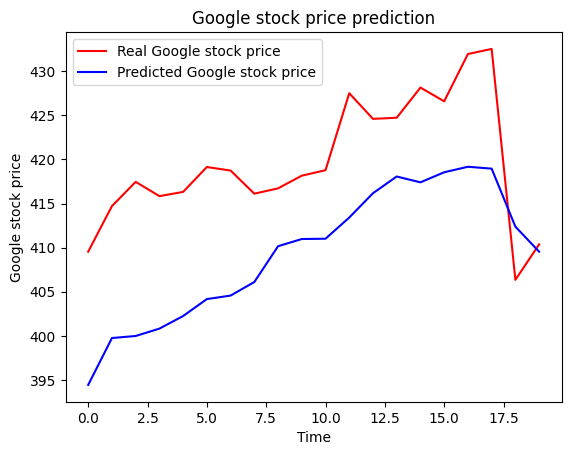

In [ ]:
plt.plot(real_stock_price, color='red', label='Real Google stock price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google stock price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Google stock price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE:', rmse)

RMSE: 11.704944234570315
